# 自定義模型和層的應用

<table class="tfo-notebook-buttons" align="left">
  <td data-segment-approved="false">     <a target="_blank" href="https://tensorflow.google.cn/guide/keras/custom_layers_and_models"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td data-segment-approved="false"><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/custom_layers_and_models.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td data-segment-approved="false">     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/custom_layers_and_models.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td data-segment-approved="false">     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/keras/custom_layers_and_models.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

## 設定
[TensorFlow 模型建立與訓練](https://tf.wiki/zh_hant/basic/models.html#tf-keras-metrics)

In [ ]:
# TensorFlow and tf.keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics

print(tf.__version__)

2.8.0


## `Layer` 類：狀態（權重）和部分計算的組合
Keras 有兩個重要的概念： **模型（Model）** 和 **層（Layer）** 。

* 層將各種計算流程和變數進行了封裝（例如基本的全連接層 (Fully Connected Layer)，CNN 的卷積層 (Convolution Layer)、池化層 (Pooling Layer)… 等）

* 模型則將各種層進行組織和連接，並封裝成一個整體，描述了如何將輸入資料通過各種層以及運算而得到輸出。在需要模型呼叫的時候，使用 `y_pred = model(X)` 的形式即可。

Keras 在 `tf.keras.layers` 下內建了深度學習中大量常用的的預定義層，同時也允許我們自定義層。

層封裝了狀態（層的“權重”）和從輸入到輸出的轉換（“call”，即層的前向傳遞）。

下面是一個密集連接的層。它具有一個狀態：變量 `w` 和 `b`。

In [ ]:
#通過繼承 tf.keras.layer 這個 Python 類別來定義自己的層。
class Linear(keras.layers.Layer):
  # init : 主要就是初始化，以及繼承
  def __init__(self, units=32, input_dim=32):
      super(Linear, self).__init__()
      
      w_init = tf.random_normal_initializer()
      self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units), dtype="float32"),trainable=True)
      
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(initial_value=b_init(shape=(units,), dtype="float32"), trainable=True)
  
  # 模型呼叫的程式碼（處理輸入並返回輸出）
  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b


您可以在某些張量輸入上通過call來使用層，這一點很像 Python 函數。

In [ ]:
x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[-0.01324114  0.03498083 -0.08151959  0.04196075]
 [-0.01324114  0.03498083 -0.08151959  0.04196075]], shape=(2, 4), dtype=float32)


請注意，權重 `w` 和 `b` 在被設置為層特性後會由層自動跟踪：

In [ ]:
assert linear_layer.weights == [linear_layer.w, linear_layer.b]

請注意，您還可以使用一種更加快捷的方式為層添加權重：`add_weight()` 方法：

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[-0.05543873  0.0844661   0.00034161  0.04071395]
 [-0.05543873  0.0844661   0.00034161  0.04071395]], shape=(2, 4), dtype=float32)


## 層可以具有不可訓練的權重

除了可訓練權重外，您還可以向層添加不可訓練權重。訓練層時，不必在反向傳播期間考慮此類權重。

以下是添加和使用不可訓練權重的方式：

In [ ]:
class ComputeSum(keras.layers.Layer):
    def __init__(self, input_dim):
        super(ComputeSum, self).__init__()
        self.total = tf.Variable(initial_value=tf.zeros((input_dim,)), trainable=False)

    def call(self, inputs):
        self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.total


x = tf.ones((2, 2))
my_sum = ComputeSum(2)
y = my_sum(x)
print(y.numpy())
y = my_sum(x)
print(y.numpy())

[2. 2.]
[4. 4.]


它是 `layer.weights` 的一部分，但被歸類為不可訓練權重：

In [ ]:
print("weights:", len(my_sum.weights))
print("non-trainable weights:", len(my_sum.non_trainable_weights))

# It's not included in the trainable weights:
print("trainable_weights:", my_sum.trainable_weights)

weights: 1
non-trainable weights: 1
trainable_weights: []


## 最佳做法：將權重創建延遲到得知輸入的形狀之後

上面的 `Linear` 層接受了一個 `input_dim` 參數，用於計算 `__init__()` 中權重 `w` 和 `b` 的形狀：

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


在許多情況下，您可能事先不知道輸入的大小，並希望在得知該值時（對層進行實例化後的某個時間）再延遲創建權重。

在 Keras API 中，我們建議您在層的 `build(self, inputs_shape)` 方法中創建層權重。如下所示：

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape): # 這裡 input_shape 是第一次運行call()時參數inputs的形狀
        # input_shape 是一個 TensorShape 類型對象，提供輸入的形狀
        # 在第一次使用該層的時候呼叫該部分程式碼，在這裡創建變數可以使得變數的形狀自適應輸入
        # 而不需要使用者額外指定變數形狀。
        # 如果已經可以完全確定變數的形狀，也可以在__init__部分創建變數
        self.w = self.add_weight(shape=(input_shape[-1], self.units),initializer="random_normal",trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


層的 `__call__()` 方法將在首次調用時自動運行構建。現在，您有了一個延遲並因此更容易使用的層：

In [ ]:
# At instantiation, we don't know on what inputs this is going to get called
linear_layer = Linear(32)

# The layer's weights are created dynamically the first time the layer is called
y = linear_layer(x)

## 基礎範例：多層感知器（MLP）

多層感知器的模型類別實現與上面的線性模型類似，使用 tf.keras.Model 和 tf.keras.layers 建構，所不同的地方在於層數增加了（顧名思義，“多層” 感知器），以及引入了非線性激活函數（這裡使用了 ReLU 函數 ， 即下方的 activation=tf.nn.relu ）。

我們建議在 `__init__()` 方法中創建此類子層（由於子層通常具有構建方法，它們將與外部層同時構建）。。

In [ ]:
class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(1)

    def call(self, inputs): 
      # 模型呼叫的程式碼（處理輸入並返回輸出）
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)


mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))  # The first call to the `mlp` will create the weights
print("weights:", len(mlp.weights))
print("trainable weights:", len(mlp.trainable_weights))

weights: 6
trainable weights: 6


## 自定義損失函數 `add_loss()` 方法

在編寫層的 `call()` 方法時，您可以在編寫訓練循環時創建想要稍後使用的損失張量。這可以通過調用 `self.add_loss(value)` 來實現：

維度是用來索引一個多維數組中某個具體數所需要最少的坐標數量。

In [ ]:
# A layer that creates an activity regularization loss
class ActivityRegularizationLayer(keras.layers.Layer):
    def __init__(self, rate=1e-2):
        super(ActivityRegularizationLayer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs

這些損失（包括由任何內部層創建的損失）可通過 `layer.losses` 取回。此屬性會在每個 `__call__()` 開始時重置到頂層，因此 `layer.losses` 始終包含在上一次前向傳遞過程中創建的損失值。

In [ ]:
class OuterLayer(keras.layers.Layer):
    def __init__(self):
        super(OuterLayer, self).__init__()
        self.activity_reg = ActivityRegularizationLayer(1e-2)

    def call(self, inputs):
        return self.activity_reg(inputs)


layer = OuterLayer()
assert len(layer.losses) == 0  # No losses yet since the layer has never been called

_ = layer(tf.zeros(1, 1))
assert len(layer.losses) == 1  # We created one loss value

# `layer.losses` gets reset at the start of each __call__
_ = layer(tf.zeros(1, 1))
assert len(layer.losses) == 1  # This is the loss created during the call above

此外，`loss` 屬性還包含為任何內部層的權重創建的正則化損失：

In [ ]:
class OuterLayerWithKernelRegularizer(keras.layers.Layer):
    def __init__(self):
        super(OuterLayerWithKernelRegularizer, self).__init__()
        self.dense = keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-3))

    def call(self, inputs):
        return self.dense(inputs)


layer = OuterLayerWithKernelRegularizer()
_ = layer(tf.zeros((1, 1)))

# This is `1e-3 * sum(layer.dense.kernel ** 2)`,
# created by the `kernel_regularizer` above.
print(layer.losses)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0016826222>]


在編寫訓練循環時應考慮這些損失，如下所示：

```python
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Iterate over the batches of a dataset.
for x_batch_train, y_batch_train in train_dataset:
  with tf.GradientTape() as tape:
    logits = layer(x_batch_train)  # Logits for this minibatch
    # Loss value for this minibatch
    loss_value = loss_fn(y_batch_train, logits)
    # Add extra losses created during this forward pass:
    loss_value += sum(model.losses)

  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
```

有關編寫訓練循環的詳細指南，請參閱[從頭開始編寫訓練循環](https://tensorflow.google.cn/guide/keras/writing_a_training_loop_from_scratch/)指南。

這些損失還可以無縫使用 `fit()`（它們會自動求和並添加到主損失中，如果有）：

In [ ]:
import numpy as np

inputs = keras.Input(shape=(3,))
outputs = ActivityRegularizationLayer()(inputs)
model = keras.Model(inputs, outputs)

# If there is a loss passed in `compile`, the regularization
# losses get added to it
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# It's also possible not to pass any loss in `compile`,
# since the model already has a loss to minimize, via the `add_loss`
# call during the forward pass!
model.compile(optimizer="adam")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 0s 58ms/step - loss: 0.0491


## 自定義評量指標 `add_metric()` 方法

 `add_metric()` 方法，用於在訓練過程中追踪數量的移動平均值。

請參考下面的 "logistic endpoint" 層。

它將預測和目標作為輸入，計算通過 `add_loss()` 追踪的損失，並計算通過 `add_metric()` 追踪的準確率。

In [ ]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


可通過 `layer.metrics` 這種方式追踪評量的指標：

In [ ]:
layer = LogisticEndpoint()

targets = tf.ones((2, 2))
logits = tf.ones((2, 2))
y = layer(targets, logits)

print("layer.metrics:", layer.metrics)
print("current accuracy value:", float(layer.metrics[0].result()))

layer.metrics: [<keras.metrics.BinaryAccuracy object at 0x7f19f512d250>]
current accuracy value: 1.0


和 `add_loss()` 一樣，這些訓練指標也是通過 `fit()` 追踪的：

In [ ]:
inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)

model.compile(optimizer="adam")

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
#使用 tf.keras.Model 的 fit 方法訓練模型
model.fit(data)

1/1 [==============================] - 0s 413ms/step - loss: 1.0262 - binary_accuracy: 0.0000e+00


## 可選擇在層上啟用序列化

如果需要將自定義層作為[函數式模型](https://tensorflow.google.cn/guide/keras/functional/)的一部分進行序列化，您可以選擇實現 `get_config()` 方法：

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),initializer="random_normal",trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


# Now you can recreate the layer from its config:
layer = Linear(64)
config = layer.get_config()
print(config)
new_layer = Linear.from_config(config)

{'units': 64}


請注意，基礎 `Layer` 類的 `__init__()` 方法會接受一些關鍵字參數，尤其是 `name` 和 `dtype`。

最好將這些參數傳遞給 `__init__()` 中的父類，並將其包含在層配置中：

In [ ]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, **kwargs):
        super(Linear, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),initializer="random_normal",trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        config = super(Linear, self).get_config()
        config.update({"units": self.units})
        return config


layer = Linear(64)
config = layer.get_config()
print(config)
new_layer = Linear.from_config(config)

{'name': 'linear_8', 'trainable': True, 'dtype': 'float32', 'units': 64}


## `call()` 方法中的特權 `training` 參數

某些層，尤其是 `BatchNormalization` 層和 `Dropout` 層，在訓練和推斷期間具有不同的行為。

對於此類層，標準做法是在 `call()` 方法中使用 `training`（布林）參數。


In [ ]:
class CustomDropout(keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs

## `Model` 類

通常，您會使用 `Layer` 來定義內部計算塊，並使用 `Model` 類來定義外部模型，即您將訓練的對象。

例如，在 ResNet50 模型中，您會有幾個子類化 `Layer` 的 ResNet 塊，以及一個包含整個 ResNet50 網絡的 `Model`。

`Model` 具有與 `Layer` 相同的 API，但有如下區別：

- `model.fit()`、`model.evaluate()`、`model.predict()`。
- 它會通過 `model.layers` 排列內部層的列表。
- 儲存方式 API（`save()`、`save_weights()`…）

實際上，`Layer` 類對應於我們在文獻中所稱的“層”（如“卷積層”或“循環層”）或“塊”（如“ResNet 塊”或“Inception 塊”）。

同時，`Model` 類對應於文獻中所稱的“模型”（如“深度學習模型”）或“網絡”（如“深度神經網絡”）。

因此，如果您想知道“我應該用 `Layer` 還是 `Model` ？

請問自己：我是否需要在它上面使用 `fit()`？我是否需要在它上面使用 `save()`？
* 如果是，則使用 `Model`。
* 如果不是，則使用 `Layer`。

例如，我們可以使用下面的 resnet 範例，用它來構建一個 `Model`，該模型可以通過 `fit()` 進行訓練，並通過 `save_weights()` 進行保存：

In [ ]:
#Residual Block:主要通過Convolution -> BatchNormalization -> Activation (Relu)，然後重複一層。
class ResBlock(layers.Layer):
  def __init__(self, filter_nums, strides=1, residual_path=False):
      super(ResBlock, self).__init__()

      self.conv_1 = layers.Conv2D(filter_nums,(3,3),strides=strides,padding='same')
      self.bn_1 = layers.BatchNormalization()
      self.act_relu = layers.Activation('relu')

      self.conv_2 = layers.Conv2D(filter_nums,(3,3),strides=1,padding='same')
      self.bn_2 = layers.BatchNormalization()
      #Shortcut的部分，這邊我們選擇使用1X1的Convolution來維持大小。
      if strides !=1:
        self.block = Sequential()
        self.block.add(layers.Conv2D(filter_nums,(1,1),strides=strides))
      else:
        self.block = lambda x:x

  #forwarding
  def call(self, inputs, training=None):

      x = self.conv_1(inputs)
      x = self.bn_1(x, training=training)
      x = self.act_relu(x)
      x = self.conv_2(x)
      x = self.bn_2(x,training=training)
      
      identity = self.block(inputs)
      outputs = layers.add([x,identity])
      outputs = tf.nn.relu(outputs)

      return outputs

In [ ]:
class ResNet(keras.Model):
  def __init__(self, layers_dims, nums_class=10):
    super(ResNet,self).__init__()
    # 此處添加初始化程式碼（包含 call 方法中會用到的層）
    self.model = Sequential([layers.Conv2D(64,(3,3),strides=(1,1)),
                             layers.BatchNormalization(),
                             layers.Activation('relu'),
                             layers.MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')])

    self.layer_1 = self.ResNet_build(64,layers_dims[0])
    self.layer_2 = self.ResNet_build(128,layers_dims[1],strides=2)   
    self.layer_3 = self.ResNet_build(256,layers_dims[2],strides=2) 
    self.layer_4 = self.ResNet_build(512,layers_dims[3],strides=2)   
    self.avg_pool = layers.GlobalAveragePooling2D()                 
    self.fc_model = layers.Dense(nums_class)

  def call(self, inputs, training=None):
    # 此處添加模型呼叫的程式碼（處理輸入並返回輸出）
    x = self.model(inputs)
    x = self.layer_1(x)        
    x = self.layer_2(x) 
    x = self.layer_3(x)                               
    x = self.layer_4(x) 
    x = self.avg_pool(x) 
    x = self.fc_model(x)
    return x

  def ResNet_build(self,filter_nums,block_nums,strides=1):
    build_model = Sequential()
    
    build_model.add(ResBlock(filter_nums,strides))

    for _ in range(1,block_nums):
      build_model.add(ResBlock(filter_nums,strides=1))
    return build_model

## VAE Model

In [ ]:
from tensorflow.keras import layers


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed


讓我們在 MNIST 上編寫一個簡單的訓練循環：

In [ ]:
original_dim = 784
vae = VariationalAutoEncoder(original_dim, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

epochs = 2

# Iterate over epochs.
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))

11501568/11490434 [==============================] - 0s 0us/step
Start of epoch 0
step 0: mean loss = 0.3482
step 100: mean loss = 0.1266
step 200: mean loss = 0.0997
step 300: mean loss = 0.0895
step 400: mean loss = 0.0845
step 500: mean loss = 0.0811
step 600: mean loss = 0.0789
step 700: mean loss = 0.0773
step 800: mean loss = 0.0761
step 900: mean loss = 0.0751
Start of epoch 1
step 0: mean loss = 0.0748
step 100: mean loss = 0.0741
step 200: mean loss = 0.0736
step 300: mean loss = 0.0731
step 400: mean loss = 0.0728
step 500: mean loss = 0.0724
step 600: mean loss = 0.0721
step 700: mean loss = 0.0718
step 800: mean loss = 0.0715
step 900: mean loss = 0.0713


請注意，由於 VAE 是 `Model` 的子類，它具有內置的訓練循環。因此，您也可以用以下方式訓練它：

In [ ]:
vae = VariationalAutoEncoder(784, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=2, batch_size=64)

Epoch 1/2
938/938 [==============================] - 5s 5ms/step - loss: 0.0747
Epoch 2/2
938/938 [==============================] - 4s 4ms/step - loss: 0.0676


## 使用 Keras API 快速建立模型


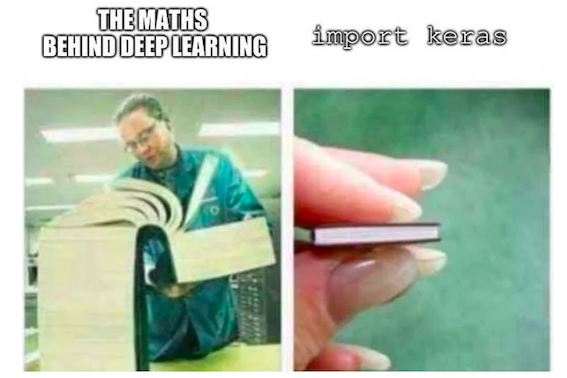

In [ ]:
original_dim = 784
intermediate_dim = 64
latent_dim = 32

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=3, batch_size=64)

Epoch 1/3
938/938 [==============================] - 5s 4ms/step - loss: 0.0749
Epoch 2/3
938/938 [==============================] - 4s 4ms/step - loss: 0.0676
Epoch 3/3
938/938 [==============================] - 4s 4ms/step - loss: 0.0676
